In [2]:
import xgboost as xgb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:

test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [5]:
train.drop("Cabin", inplace=True, axis=1)

In [6]:
train['Age'] = train.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))
train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,26.507589,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,C


In [7]:
train.drop("Name", inplace=True, axis=1)
train.drop("Ticket", inplace=True, axis=1)
train["Sex"] = train["Sex"].map({'male':1, 'female':0})
embarked = pd.get_dummies(train["Embarked"], drop_first=True)

train = pd.concat([train, embarked], axis=1)

train.drop("Embarked", inplace=True, axis=1)
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Q,S
0,1,0,3,1,22.00,1,0,7.2500,0,1
1,2,1,1,0,38.00,1,0,71.2833,0,0
2,3,1,3,0,26.00,0,0,7.9250,0,1
3,4,1,1,0,35.00,1,0,53.1000,0,1
4,5,0,3,1,35.00,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.00,0,0,13.0000,0,1
887,888,1,1,0,19.00,0,0,30.0000,0,1
888,889,0,3,0,21.75,1,2,23.4500,0,1
889,890,1,1,1,26.00,0,0,30.0000,0,0


In [8]:
test['Age'] = test.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))
test.drop("Cabin", inplace=True, axis=1)
test.drop("Name", inplace=True, axis=1)
test.drop("Ticket", inplace=True, axis=1)
test["Sex"] = test["Sex"].map({'male':1, 'female':0})
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

In [9]:
embarked_test = pd.get_dummies(test["Embarked"], drop_first=True)
test = pd.concat([test, embarked_test], axis=1)
test.drop("Embarked", inplace=True, axis=1)

test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Q,S
0,892,3,1,34.500000,0,0,7.8292,1,0
1,893,3,0,47.000000,1,0,7.0000,0,1
2,894,2,1,62.000000,0,0,9.6875,1,0
3,895,3,1,27.000000,0,0,8.6625,0,1
4,896,3,0,22.000000,1,1,12.2875,0,1
...,...,...,...,...,...,...,...,...,...
413,1305,3,1,24.525104,0,0,8.0500,0,1
414,1306,1,0,39.000000,0,0,108.9000,0,0
415,1307,3,1,38.500000,0,0,7.2500,0,1
416,1308,3,1,24.525104,0,0,8.0500,0,1


In [10]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]

In [11]:
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)

In [19]:
params1 = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [20]:
cv_results = xgb.cv(dtrain=data_dmatrix, params= params ,
           nfold=5, num_boost_round=50, early_stopping_rounds=50, metrics="rmse", as_pandas=True, seed=123)

cv_results.head()

[19:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.492672,0.000616,0.493543,0.001224
1,0.483378,0.003983,0.484647,0.005737
2,0.477465,0.006444,0.478978,0.008088
3,0.471950,0.005301,0.473808,0.008022
4,0.468919,0.006157,0.471037,0.009198


In [21]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.396585
Name: test-rmse-mean, dtype: float64


In [22]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[19:01:50] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


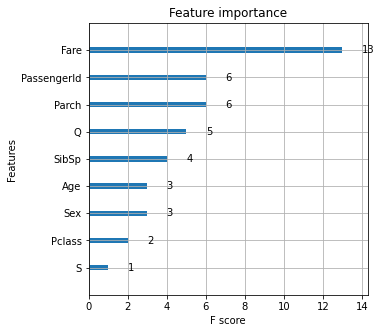

In [23]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [31]:
params2 = {"objective":"reg:linear",'colsample_bytree': 0.8,'learning_rate': 0.2,
                'max_depth': 10, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params= params ,
           nfold=5, num_boost_round=50, early_stopping_rounds=50, metrics="rmse", as_pandas=True, seed=123)
print((cv_results["test-rmse-mean"]).tail(1))

[19:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
49    0.396585
Name: test-rmse-mean, dtype: float64


In [32]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[19:05:16] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


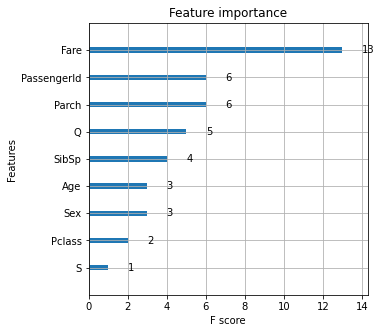

In [33]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [34]:

param_grid = {'colsample_bytree': [0.2,0.4,0.6,0.8], 
              'learning_rate': [0.01,0.05,0.1,0.15,0.2], 
              'max_depth': [3,5,7,9]
             }

In [35]:
# make item combination for param_grid dict
import itertools as it
s = sorted(param_grid)
print(s)
combination = it.product(*(param_grid[Name] for Name in s))

['colsample_bytree', 'learning_rate', 'max_depth']


In [36]:
combination_list = list(combination)
print(combination_list)

[(0.2, 0.01, 3), (0.2, 0.01, 5), (0.2, 0.01, 7), (0.2, 0.01, 9), (0.2, 0.05, 3), (0.2, 0.05, 5), (0.2, 0.05, 7), (0.2, 0.05, 9), (0.2, 0.1, 3), (0.2, 0.1, 5), (0.2, 0.1, 7), (0.2, 0.1, 9), (0.2, 0.15, 3), (0.2, 0.15, 5), (0.2, 0.15, 7), (0.2, 0.15, 9), (0.2, 0.2, 3), (0.2, 0.2, 5), (0.2, 0.2, 7), (0.2, 0.2, 9), (0.4, 0.01, 3), (0.4, 0.01, 5), (0.4, 0.01, 7), (0.4, 0.01, 9), (0.4, 0.05, 3), (0.4, 0.05, 5), (0.4, 0.05, 7), (0.4, 0.05, 9), (0.4, 0.1, 3), (0.4, 0.1, 5), (0.4, 0.1, 7), (0.4, 0.1, 9), (0.4, 0.15, 3), (0.4, 0.15, 5), (0.4, 0.15, 7), (0.4, 0.15, 9), (0.4, 0.2, 3), (0.4, 0.2, 5), (0.4, 0.2, 7), (0.4, 0.2, 9), (0.6, 0.01, 3), (0.6, 0.01, 5), (0.6, 0.01, 7), (0.6, 0.01, 9), (0.6, 0.05, 3), (0.6, 0.05, 5), (0.6, 0.05, 7), (0.6, 0.05, 9), (0.6, 0.1, 3), (0.6, 0.1, 5), (0.6, 0.1, 7), (0.6, 0.1, 9), (0.6, 0.15, 3), (0.6, 0.15, 5), (0.6, 0.15, 7), (0.6, 0.15, 9), (0.6, 0.2, 3), (0.6, 0.2, 5), (0.6, 0.2, 7), (0.6, 0.2, 9), (0.8, 0.01, 3), (0.8, 0.01, 5), (0.8, 0.01, 7), (0.8, 0.01, 9),

In [37]:
# k-fold with index pair return
def kfold_index(X_train, k):
    if k < 1:
        print('K cannot be smaller than 1')
        return
    else:
        l = X_train.shape[0]
        tail = l % k
        q = l // k
        index = [0]
        output_index = []
        
        for i in range(1, tail):
            index.append(i*q+1)
        for j in range(tail, k+1):
            index.append(j*q+tail)
        for m in range(len(index)-1):
            output_index.append([index[m], index[m+1]])
        
        return output_index

In [45]:
def cv(model, X_train, Y_train, k):
    index = kfold_index(X_train, k)
    
    # train each sub-combination
    auc = []
    for i in range(k):
        
        cv_xtest = X_train.iloc[index[i][0]:index[i][1],:]
        cv_ytest = Y_train.iloc[index[i][0]:index[i][1],]
        
        # drop the test sub-set
        cv_xtrain = X_train.drop(X_train.index[index[i][0]:index[i][1]])
        cv_ytrain = Y_train.drop(X_train.index[index[i][0]:index[i][1]])
        
        #model.fit(cv_xtrain, cv_ytrain.values.reshape(-1))
        
        # calculate the auc as the evaluation metric
        fpr, tpr, threshold = roc_curve(cv_ytest, model.predict_proba(cv_xtest)[:,1])
        aa = metrics.auc(fpr, tpr)
        auc.append(aa)
    
    return np.mean(auc)

In [46]:

for i in combination_list:
    rf_clf = xgb.train(params = {'max_depth' : i[2], 
                       'colsample_bytree' : i[0],   
                       'learning_rate' : i[1]}, dtrain=data_dmatrix, num_boost_round=10)
    scc = cv(rf_clf, X_train, Y_train, 10)
    score = 0
    
    if scc >= score:
        score = scc
        opt = i

print(score, opt)

AttributeError: 'Booster' object has no attribute 'predict_proba'